In [10]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import IPython.display as dp

from pathlib import Path

from typing import Optional
from typing import Optional
from paddle.io import Dataset

import os
import paddle
from paddle import inference

In [11]:
# inference
def get_predictor(
        model_dir: Optional[os.PathLike]=None,
        model_file: Optional[os.PathLike]=None,
        params_file: Optional[os.PathLike]=None,
        device: str='cpu',
        # for gpu
        use_trt: bool=False,
        # for trt
        use_dynamic_shape: bool=True,
        min_subgraph_size: int=5,
        # for cpu
        cpu_threads: int=1,
        use_mkldnn: bool=False,
        # for trt or mkldnn
        precision: int="fp32"):
    """
    Args:
        model_dir (os.PathLike): root path of model.pdmodel and model.pdiparams.
        model_file (os.PathLike): name of model_file.
        params_file (os.PathLike): name of params_file.
        device (str): Choose the device you want to run, it can be: cpu/gpu, default is cpu.
        use_trt (bool): whether to use TensorRT or not in GPU.
        use_dynamic_shape (bool): use dynamic shape or not in TensorRT.
        use_mkldnn (bool): whether to use MKLDNN or not in CPU.
        cpu_threads (int): num of thread when use CPU.
        precision (str): mode of running (fp32/fp16/bf16/int8).  
    """
    rerun_flag = False
    if device != "gpu" and use_trt:
        raise ValueError(
            "Predict by TensorRT mode: {}, expect device=='gpu', but device == {}".
            format(precision, device))

    config = inference.Config(
        str(Path(model_dir) / model_file), str(Path(model_dir) / params_file))
    config.enable_memory_optim()
    config.switch_ir_optim(True)
    if device == "gpu":
        config.enable_use_gpu(100, 0)
    else:
        config.disable_gpu()
        config.set_cpu_math_library_num_threads(cpu_threads)
        if use_mkldnn:
            # fp32
            config.enable_mkldnn()
            if precision == "int8":
                config.enable_mkldnn_int8({
                    "conv2d_transpose", "conv2d", "depthwise_conv2d", "pool2d",
                    "transpose2", "elementwise_mul"
                })
                # config.enable_mkldnn_int8()
            elif precision in {"fp16", "bf16"}:
                config.enable_mkldnn_bfloat16()
            print("MKLDNN with {}".format(precision))
    if use_trt:
        if precision == "bf16":
            print("paddle trt does not support bf16, switching to fp16.")
            precision = "fp16"
        precision_map = {
            "int8": inference.Config.Precision.Int8,
            "fp32": inference.Config.Precision.Float32,
            "fp16": inference.Config.Precision.Half,
        }
        assert precision in precision_map.keys()
        pdtxt_name = model_file.split(".")[0] + "_" + precision + ".txt"
        if use_dynamic_shape:
            dynamic_shape_file = os.path.join(model_dir, pdtxt_name)
            if os.path.exists(dynamic_shape_file):
                config.enable_tuned_tensorrt_dynamic_shape(dynamic_shape_file,
                                                           True)
                # for fastspeech2
                config.exp_disable_tensorrt_ops(["reshape2"])
                print("trt set dynamic shape done!")
            else:
                # In order to avoid memory overflow when collecting dynamic shapes, it is changed to use CPU.
                config.disable_gpu()
                config.set_cpu_math_library_num_threads(10)
                config.collect_shape_range_info(dynamic_shape_file)
                print("Start collect dynamic shape...")
                rerun_flag = True

        if not rerun_flag:
            print("Tensor RT with {}".format(precision))
            config.enable_tensorrt_engine(
                workspace_size=1 << 30,
                max_batch_size=1,
                min_subgraph_size=min_subgraph_size,
                precision_mode=precision_map[precision],
                use_static=True,
                use_calib_mode=False, )

    predictor = inference.create_predictor(config)
    return predictor

def get_voc_output(voc_predictor, input):
    voc_input_names = voc_predictor.get_input_names()
    mel_handle = voc_predictor.get_input_handle(voc_input_names[0])
    mel_handle.reshape(input.shape)
    mel_handle.copy_from_cpu(input)

    voc_predictor.run()
    voc_output_names = voc_predictor.get_output_names()
    voc_output_handle = voc_predictor.get_output_handle(voc_output_names[0])
    wav = voc_output_handle.copy_to_cpu()
    return wav

# new get_am_output for SpeedySpeech
def get_am_output(
        phone_ids,
        tone_ids,
        am_predictor: paddle.nn.Layer):
    am_input_names = am_predictor.get_input_names()
    phones = np.array(phone_ids)
    phones_handle = am_predictor.get_input_handle(am_input_names[0])
    phones_handle.reshape(phones.shape)
    phones_handle.copy_from_cpu(phones)

    tones = np.array(tone_ids)
    tones_handle = am_predictor.get_input_handle(am_input_names[1])
    tones_handle.reshape(tones.shape)
    tones_handle.copy_from_cpu(tones)

    am_predictor.run()
    am_output_names = am_predictor.get_output_names()
    am_output_handle = am_predictor.get_output_handle(am_output_names[0])
    am_output_data = am_output_handle.copy_to_cpu()
    return am_output_data

## SpeedySpeech

In [12]:
# pwgan 只初始化一次
model_file = 'pwgan_csmsc.pdmodel'
params_file = 'pwgan_csmsc.pdiparams'
model_dir = './pwgan_csmsc_static_1.4.0'
device = 'cpu'
precision = 'fp32'
voc_predictor = get_predictor(
        model_dir=model_dir,
        model_file=model_file,
        params_file=params_file,
        device=device,
        use_mkldnn=True,
        precision=precision
    )

MKLDNN with fp32


### fp32 SpeedySpeech + fp32 pwgan  静态图推理

In [13]:
device = 'cpu'
precision = 'fp32'
model_file = 'speedyspeech_csmsc.pdmodel'
params_file = 'speedyspeech_csmsc.pdiparams'
model_dir = './exp/default/inference/'
am_predictor = get_predictor(
        model_dir=model_dir,
        model_file=model_file,
        params_file=params_file,
        device=device,
        use_mkldnn=True,
        precision=precision
    )

# 昨日，这名伤者与医生全部被警方依法刑事拘留
phone_ids = [87, 78, 58, 34, 62, 88, 15, 49, 38, 60, 6, 88, 15, 81, 24, 60, 18, 57, 82, 11, 66, 11, 16, 46, 38, 21, 6, 62, 24, 21, 2, 86, 38, 60, 34, 46, 81, 48, 43]
tone_ids = [0, 2, 0, 4, 0, 0, 4, 0, 2, 0, 1, 0, 2, 3, 1, 0, 1, 0, 2, 0, 4, 0, 4, 0, 3, 0, 1, 0, 1, 0, 3, 0, 2, 0, 4, 0, 1, 0, 2]
phone_ids = np.array(phone_ids)
tone_ids = np.array(tone_ids)
mel1 = get_am_output(phone_ids=phone_ids, tone_ids=tone_ids, am_predictor=am_predictor)

MKLDNN with fp32


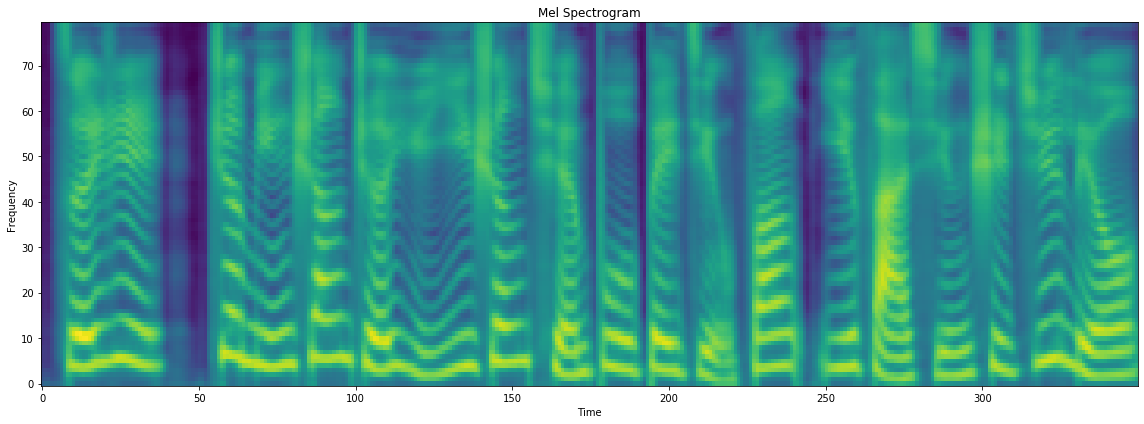

In [14]:
# 绘制 mel 频谱图
fig, ax = plt.subplots(figsize=(16, 6))
im = ax.imshow(mel1.T, aspect='auto',origin='lower')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()

In [15]:
# 声码器推理
wav1 = get_voc_output(voc_predictor=voc_predictor, input=mel1)

In [16]:
# 播放音频
wav_path = 'ss_fp32_infer.wav'
sf.write(wav_path, wav1, samplerate=24000)
dp.Audio(wav_path, rate=24000)

### int8 SpeedySpeech + fp32 pwgan  静态图推理
由于每次导出的量化模型都不一样（为什么），这一条可能会挂掉

In [24]:
device = 'cpu'
precision = 'int8'
model_file = 'speedyspeech_csmsc.pdmodel'
params_file = 'speedyspeech_csmsc.pdiparams'
model_dir = './exp/default/inference/speedyspeech_csmsc_quant'
am_predictor_2 = get_predictor(
        model_dir=model_dir,
        model_file=model_file,
        params_file=params_file,
        device=device,
        use_mkldnn=True,
        precision=precision
    )

# 昨日，这名伤者与医生全部被警方依法刑事拘留
phone_ids = [87, 78, 58, 34, 62, 88, 15, 49, 38, 60, 6, 88, 15, 81, 24, 60, 18, 57, 82, 11, 66, 11, 16, 46, 38, 21, 6, 62, 24, 21, 2, 86, 38, 60, 34, 46, 81, 48, 43]
tone_ids = [0, 2, 0, 4, 0, 0, 4, 0, 2, 0, 1, 0, 2, 3, 1, 0, 1, 0, 2, 0, 4, 0, 4, 0, 3, 0, 1, 0, 1, 0, 3, 0, 2, 0, 4, 0, 1, 0, 2]
phone_ids = np.array(phone_ids)
tone_ids = np.array(tone_ids)
mel2 = get_am_output(phone_ids=phone_ids, tone_ids=tone_ids, am_predictor=am_predictor_2)

MKLDNN with int8


ValueError: (InvalidArgument) Broadcast dimension mismatch. Operands could not be broadcast together with the shape of X = [1, 352, 128] and the shape of Y = [1, 324, 128]. Received [352] in X is not equal to [324] in Y at i:1.
  [Hint: Expected x_dims_array[i] == y_dims_array[i] || x_dims_array[i] <= 1 || y_dims_array[i] <= 1 == true, but received x_dims_array[i] == y_dims_array[i] || x_dims_array[i] <= 1 || y_dims_array[i] <= 1:0 != true:1.] (at /paddle/paddle/phi/kernels/funcs/common_shape.h:85)
  [operator < elementwise_add > error]

In [ ]:
# 绘制 mel 频谱图 -> 看不出内容，低频部分的频谱几乎都是平的，所以也听不出什么内容
fig, ax = plt.subplots(figsize=(16, 6))
im = ax.imshow(mel2.T, aspect='auto',origin='lower')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()

In [ ]:
# 声码器推理
wav2 = get_voc_output(voc_predictor=voc_predictor, input=mel2)

In [ ]:
# 播放音频
wav_path = 'ss_int8_infer.wav'
sf.write(wav_path, wav2, samplerate=24000)
dp.Audio(wav_path, rate=24000)

### int8 ss exe.run() + fp32 pwgan

In [25]:
paddle.enable_static()
model_dir = './exp/default/inference/speedyspeech_csmsc_quant/speedyspeech_csmsc'
exe = paddle.static.Executor(paddle.CUDAPlace(0))
[speedyspeech_inference, feed_target_names, fetch_targets] = paddle.static.load_inference_model(model_dir, exe)
# 009901
phone_ids = [87, 78, 58, 34, 62, 88, 15, 49, 38, 60, 6, 88, 15, 81, 24, 60, 18, 57, 82, 11, 66, 11, 16, 46, 38, 21, 6, 62, 24, 21, 2, 86, 38, 60, 34, 46, 81, 48, 43]
tone_ids = [0, 2, 0, 4, 0, 0, 4, 0, 2, 0, 1, 0, 2, 3, 1, 0, 1, 0, 2, 0, 4, 0, 4, 0, 3, 0, 1, 0, 1, 0, 3, 0, 2, 0, 4, 0, 1, 0, 2]
phone_ids = np.array(phone_ids)
tone_ids = np.array(tone_ids)
mel_runexe = exe.run(speedyspeech_inference, feed={feed_target_names[0]:phone_ids, feed_target_names[1]:tone_ids}, fetch_list=fetch_targets)

In [26]:
mel_runexe = np.array(mel_runexe)
mel_runexe = mel_runexe[0]

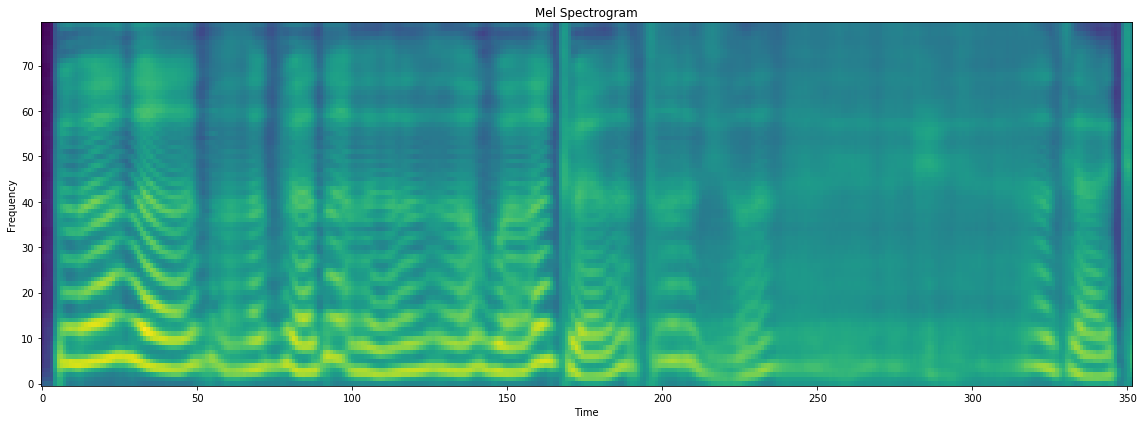

In [27]:
# 绘制 mel 频谱图 -> 发现 run.exe() 的输出不符合预期, 所以是 PaddleSlim 产出模型的问题
# 和静态图推理的结果在 1e-2 上有一些精度差异
fig, ax = plt.subplots(figsize=(16, 6))
im = ax.imshow(mel_runexe.T, aspect='auto',origin='lower')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()

In [28]:
# 声码器推理
wav3 = get_voc_output(voc_predictor=voc_predictor, input=mel_runexe)

In [29]:
# 播放音频
wav_path = 'ss_int8_runexe.wav'
sf.write(wav_path, wav3, samplerate=24000)
dp.Audio(wav_path, rate=24000)

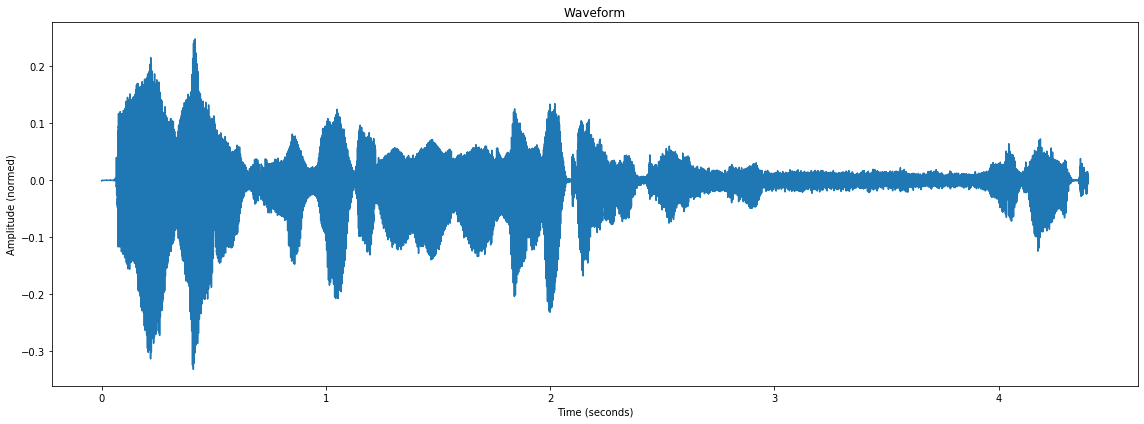

In [30]:
# 绘制波形图
wave_data = wav3.T
time = np.arange(0, wave_data.shape[1]) * (1.0 / 24000)
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(time, wave_data[0])
plt.title('Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (normed)')
plt.tight_layout()